# MNIST (Modified National Institute of Standards and Technology)

This week we do everything on MNIST database due to time constraints: 
https://en.wikipedia.org/wiki/MNIST_database

![MNIST](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)


In [ ]:
# Imports
!pip install --upgrade -q gspread
!pip install 'google-auth==1.16.1'
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
import datetime
import pytz

tz = pytz.timezone('Europe/Berlin')

gc = gspread.authorize(GoogleCredentials.get_application_default())

The first time you run this there is probably an error. Just click on "RUNTIME" --> "RESTART RUNTIME" and run this cell again.

In [ ]:
student_name = "FlorianH"
assert student_name != "yourName"

In [ ]:
# init google sheet methods for task submitting
gsheet = gc.open_by_url("https://docs.google.com/spreadsheets/d/1MZcZXXADcBUHjrdFIRNSAhE0oChqx4sRJ2odUCJ6qJ4/edit?usp=sharing")

def write_result(task_number, result=None):
  if task_number == 'homework':
    worksheet = gsheet.worksheet("homework".format(task_number))
  else:
    worksheet = gsheet.worksheet("task{}".format(task_number))
  current_time = datetime.datetime.now(tz).strftime("%X")
  current_date = str(datetime.date.today())
  if result:
    worksheet.append_row([student_name, current_time, current_date, result])
    print("Task {} successfully solved by {} at {} with result: {}".format(task_number, student_name, current_time, result))
  else:
    worksheet.append_row([student_name, current_time, current_date])
    print("Task {} successfully solved by {} at {}".format(task_number, student_name, current_time))

print("Reporting enabled - write_result(number_of_task, result='your result') ")


Reporting enabled - write_result(number_of_task, result='your result') 


In [ ]:
# quick check everything is working for you

my_favorite_animal = 'stingray'
assert my_favorite_animal, 'What is your favorite animal???!'

write_result(0, my_favorite_animal)

Task 0 successfully solved by FlorianH at 15:52:56 with result: stingray


In [ ]:
# names for our labels = just the digits
classes=[str(i) for i in range(10)]

In [ ]:
import torchvision.transforms as transforms
# define the transformations the images go through each time it is used for training
# includes augmentation AND normalization as described above
augmentation_train = transforms.Compose([
                                  # randomly perform a horizontal flip of the image
                                  transforms.RandomHorizontalFlip(),
                                  # rotate the image with a angle from 0 to 60 (chosen randomly)
                                  transforms.RandomRotation(degrees=60),
                                  # convert the image into a tensor so it can be processed by the GPU
                                  transforms.ToTensor(),
                                  # normalize the image with the mean and std of ImageNet
                                   ])


# no augmentation for the test data only resizing, conversion to tensor and normalization
augmentation_test = transforms.Compose([
                    transforms.ToTensor(),
                    ])

# Task 1: load the MNIST dataset that is provided by pytorch 
Here's an overview of datasets
https://pytorch.org/docs/stable/torchvision/datasets.html

Hints:
- datasets can be found in torchvision.dataset.
- root can just be your base folder e.g. "."
- pick the test part for validation
- don't forget to add the augmentations from above
- make sure to enable the download


In [ ]:
import torchvision
toy_dataset_train = torchvision.datasets.MNIST(root='.', train=True, transform = augmentation_train, download=True)
toy_dataset_val = torchvision.datasets.MNIST(root='.', train=False, transform = augmentation_test, download=True)

In [ ]:
text = f"\n\nSize of training dataset: {len(toy_dataset_train)} \nSize of validation set: {len(toy_dataset_val)}"
assert (len(toy_dataset_train)+len(toy_dataset_val))==70000, 'Hmm? Is the MNIST dataset loaded?'
write_result(1, text)

Task 1 successfully solved by FlorianH at 15:52:59 with result: 

Size of training dataset: 60000 
Size of validation set: 10000


In [ ]:
# import of a couple more modules we need later for progress bars and plots
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Declare the network
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on device:",device)
num_classes=10

class OurNet(nn.Module):
    def __init__(self):
        super(OurNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (3,3)) 
        self.fc1   = nn.Linear(16*13*13, 120)
        self.fc2   = nn.Linear(120, num_classes)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Running on device: cuda


In [ ]:
# make sure we are running on GPU
assert str(device) == "cuda", 'If this fails maybe change the runtime: Runtime -> Change runtime type'
print('Nice! Running on the GPU')

Nice! Running on the GPU


In [ ]:
# declare network and send it to device=cuda
net = OurNet()
net = net.to(device)
summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 26, 26]             880
            Linear-3                  [-1, 120]         324,600
            Linear-4                   [-1, 10]           1,210
Total params: 326,846
Trainable params: 326,846
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.25
Estimated Total Size (MB): 1.37
----------------------------------------------------------------


In [ ]:
# Median Frequency Balancing

import numpy as np

# get the class labels of each image
class_labels = toy_dataset_train.targets
# empty array for counting instance of each class
count_labels = np.zeros(len(classes))
# empty array for weights of each class
class_weights = np.zeros(len(classes))

# populate the count array
for l in class_labels:
  count_labels[l] += 1

# get median count
median_freq = np.median(count_labels)
#print(median_freq)
#print(count_labels)

# calculate the weigths
for i in range(len(classes)):
  class_weights[i] = median_freq/count_labels[i]

# print the weights
for i in range(len(classes)):
    print(classes[i],":", class_weights[i])

0 : 1.0021948336991389
1 : 0.8804509047760308
2 : 0.9963074857334676
3 : 0.9681944217908988
4 : 1.016090380006847
5 : 1.0950009223390518
6 : 1.0030415680973301
7 : 0.9474860335195531
8 : 1.0145274312083405
9 : 0.9978147587829888


Now we define the loss function with the weights

In [ ]:
# put the weights on our device
class_weights = torch.FloatTensor(class_weights).to(device)

# Task 2: define the loss for multicalss classificaiton

Overview of losses available: https://pytorch.org/docs/stable/nn.html#loss-functions

Hints:
- CrossEntropy-Loss is a good choice
- use the nn module we have already imported as nn.
- dont forget to add the weights we just put on our device for class imbalance

In [ ]:
criterion = nn.CrossEntropyLoss(class_weights)

In [ ]:
# submitt your results
assert criterion.weight is not None, 'Did you specify the weight argument?'
write_result(2, result=str(criterion))

Task 2 successfully solved by FlorianH at 15:53:00 with result: CrossEntropyLoss()


# Evaluation functions

Here we write a function which calculates the accuracy of model based on the validation dataset.

In [ ]:
from sklearn.metrics import accuracy_score

def get_num_correct(predicted, labels):
    '''
    This function is used to decide if the predicted and ground truth classes are same or not.
    args: 
      predicted = output of model
      labels = true output
    '''
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    # correct = [1,1,1,1,2,3,4,5] predicted = [1,2,1,1,,2,3,4,6]
    return batch_len, correct

def evaluate(model, val_loader):
    '''
    This function calculates the total accuracy of the model on the validation set.
    args:
      model = the network we want to evaluate
      val_loader = the validation data loader
    '''
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_num_correct(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

# Training Loop

In [ ]:
# define the batch size for training, val and testing
batch_size, validation_batch_size = 4096, 4096

import datetime
start_time = datetime.datetime.now()
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=1e-2)

num_w = 0
# create and instance of a dataloader for training
train_data_loader = torch.utils.data.DataLoader(toy_dataset_train, batch_size=batch_size, shuffle=True,num_workers=num_w)
validation_data_loader = torch.utils.data.DataLoader(toy_dataset_val, batch_size=validation_batch_size, shuffle=True,  num_workers=num_w)
# number of loops over the dataset

num_epochs = 5
accuracy = []
val_accuracy = []
losses = []
val_losses = []

print("Started Training")
epoch = 0
running_loss = 0.0
correct_total= 0.0
num_samples_total=0.0
train_accuracy = 0.0
val_acc=0.0
val_loss = 0.0
print('Epoch: %d' %(epoch+1))
print('Train Loss: %.3f  Train Accuracy:%.3f' %(running_loss, train_accuracy))
print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

for epoch in tnrange(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    
    print("...")
    for i, data in tqdm_notebook(enumerate(train_data_loader)):
        if i % 2 == 0:
            print(f"Iteration: {i+1}/{len(train_data_loader)}")
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_num_correct(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Train Loss: %.3f  Train Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')
end_time = datetime.datetime.now()
delta = end_time -start_time
print("Time for training of {} Epochs is {}s".format(num_epochs,delta.seconds))

Started Training
Epoch: 1
Train Loss: 0.000  Train Accuracy:0.000
Validation Loss: 0.000  Val Accuracy: 0.000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Iteration: 1/15
Iteration: 3/15
Iteration: 5/15
Iteration: 7/15
Iteration: 9/15
Iteration: 11/15
Iteration: 13/15
Iteration: 15/15

Epoch: 1
Train Loss: 1.621  Train Accuracy:0.431
Validation Loss: 0.825  Val Accuracy: 0.748
...


Iteration: 1/15
Iteration: 3/15
Iteration: 5/15
Iteration: 7/15
Iteration: 9/15
Iteration: 11/15
Iteration: 13/15
Iteration: 15/15

Epoch: 2
Train Loss: 0.802  Train Accuracy:0.748
Validation Loss: 0.462  Val Accuracy: 0.858
...


Iteration: 1/15
Iteration: 3/15
Iteration: 5/15
Iteration: 7/15
Iteration: 9/15
Iteration: 11/15
Iteration: 13/15
Iteration: 15/15

Epoch: 3
Train Loss: 0.533  Train Accuracy:0.834
Validation Loss: 0.326  Val Accuracy: 0.893
...


Iteration: 1/15
Iteration: 3/15
Iteration: 5/15
Iteration: 7/15
Iteration: 9/15
Iteration: 11/15
Iteration: 13/15
Iteration: 15/15

Epoch: 4
Train Loss: 0.381  Train Accuracy:0.882
Validation Loss: 0.214  Val Accuracy: 0.931
...


Iteration: 1/15
Iteration: 3/15
Iteration: 5/15
Iteration: 7/15
Iteration: 9/15
Iteration: 11/15
Iteration: 13/15
Iteration: 15/15

Epoch: 5
Train Loss: 0.287  Train Accuracy:0.911
Validation Loss: 0.181  Val Accuracy: 0.943

Finished Training
Time for training of 5 Epochs is 63s


# Task 3: Why are the validation metrics better than the training metrics???
Didn't we learn, that this should be the other way around?!

In [ ]:
# submitt your results
my_answer = 'no augmentation used during validation'
assert my_answer is not None, 'Give it a try'
write_result(3, result=my_answer)

Task 3 successfully solved by FlorianH at 15:54:05 with result: no augmentation used during validation


# Train and Validation Curves

To better understand whether our network is actually learning something, we plot the training and validation curves.

There are two types of curves:
- Loss Curves: Plotting the trend of the loss per epoch.
- Accuracy Curves: Plotting accuracy, that is the performance of our model per epoch.

5


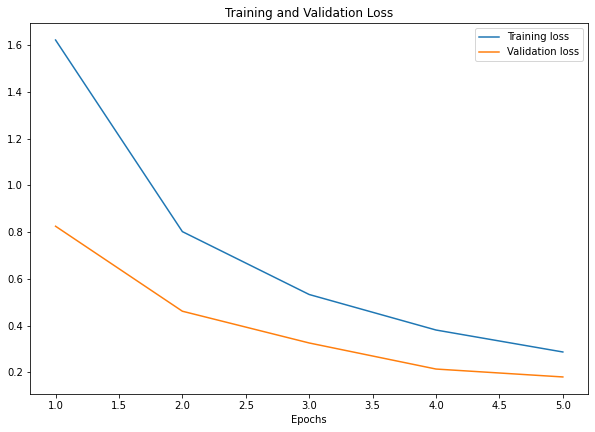

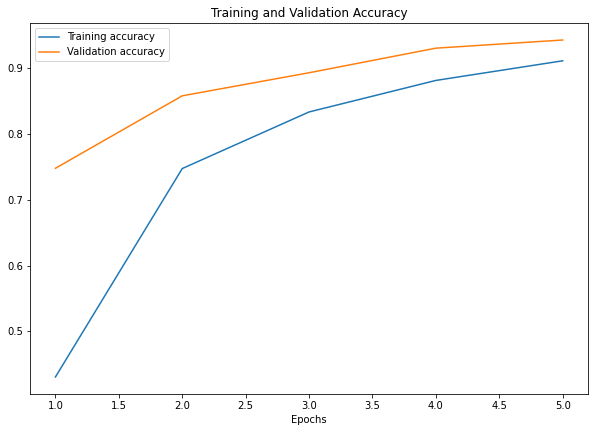

In [ ]:
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline 
num_epochs=5
print(num_epochs)
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
#plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
#plt.figure()
plt.show()



# Common Training Errors

Let us look at some errors and how to detect them.



## Data Scarcity

We need enough data to learn a good model. Less data means less learning.

Let's see how the performance is affected when we have less data.


In [ ]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on:",device)
class OurNetBig(nn.Module):
    def __init__(self):
        super(OurNetBig, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (3,3), padding=2)
        self.conv3 = nn.Conv2d(16, 32, (3,3)) 
        self.fc1   = nn.Linear(32*13*13, 1000)
        self.fc2   = nn.Linear(1000, 120)
        self.fc3   = nn.Linear(120, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
net_data = OurNetBig()
net_data = net_data.to(device)
summary(net_data, input_size=(1,28,28))

Running on: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 30, 30]             880
            Conv2d-3           [-1, 32, 13, 13]           4,640
            Linear-4                 [-1, 1000]       5,409,000
            Linear-5                  [-1, 120]         120,120
            Linear-6                   [-1, 10]           1,210
Total params: 5,536,006
Trainable params: 5,536,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 21.12
Estimated Total Size (MB): 21.32
----------------------------------------------------------------


In [ ]:
# we use the test data for training instead.
from torch.utils.data import Subset
batch_size = 50
subset_size = 200

length_dataset = [i for i in range(subset_size)]
small_toy_dataset_train = Subset(toy_dataset_train,length_dataset)
train_data_loader_small = torch.utils.data.DataLoader(small_toy_dataset_train, batch_size=batch_size, shuffle=True,num_workers=4)
validation_data_loader = torch.utils.data.DataLoader(toy_dataset_val, batch_size=batch_size, shuffle=True,  num_workers=4)

print(f"small dataset size: {len(small_toy_dataset_train)} batch_size: {batch_size} number of batches in dataloader: {len(train_data_loader_small)} ")


small dataset size: 200 batch_size: 50 number of batches in dataloader: 4 


In [ ]:
def weight_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)

net_data.apply(weight_init)

OurNetBig(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=5408, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [ ]:
# number of loops over the dataset
# optimizer
import torch.optim as optim 


num_epochs = 25
accuracy = []
val_accuracy = []
losses = []
val_losses = []
running_loss= 0.0
train_accuracy = 0.0
val_loss = 0.0
val_acc = 0.0
epoch=0

print('Epoch: %d' %(epoch+1))
print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

# intialize the network
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_data.parameters(), lr=1e-2)
print(net_data)
print("Started Training")

for epoch in tnrange(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in tqdm_notebook(enumerate(train_data_loader_small)):
        #print(f"Iteration: {i+1}/{len(train_data_loader_small)}")
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_data(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_num_correct(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader_small)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net_data, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

Epoch: 1
Loss: 0.000  Accuracy:0.000
Validation Loss: 0.000  Val Accuracy: 0.000
OurNetBig(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=5408, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)
Started Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch: 1
Loss: 3.128  Accuracy:0.090
Validation Loss: 2.301  Val Accuracy: 0.103



Epoch: 2
Loss: 2.320  Accuracy:0.075
Validation Loss: 2.308  Val Accuracy: 0.114



Epoch: 3
Loss: 2.298  Accuracy:0.130
Validation Loss: 2.301  Val Accuracy: 0.114



Epoch: 4
Loss: 2.296  Accuracy:0.130
Validation Loss: 2.312  Val Accuracy: 0.165



Epoch: 5
Loss: 2.293  Accuracy:0.150
Validation Loss: 2.300  Val Accuracy: 0.114



Epoch: 6
Loss: 2.282  Accuracy:0.140
Validation Loss: 2.296  Val Accuracy: 0.117



Epoch: 7
Loss: 2.259  Accuracy:0.190
Validation Loss: 2.294  Val Accuracy: 0.117



Epoch: 8
Loss: 2.237  Accuracy:0.210
Validation Loss: 2.228  Val Accuracy: 0.276



Epoch: 9
Loss: 2.103  Accuracy:0.300
Validation Loss: 2.111  Val Accuracy: 0.267



Epoch: 10
Loss: 1.972  Accuracy:0.245
Validation Loss: 1.921  Val Accuracy: 0.345



Epoch: 11
Loss: 1.764  Accuracy:0.395
Validation Loss: 1.810  Val Accuracy: 0.402



Epoch: 12
Loss: 1.766  Accuracy:0.345
Validation Loss: 1.762  Val Accuracy: 0.416



Epoch: 13
Loss: 1.615  Accuracy:0.440
Validation Loss: 1.629  Val Accuracy: 0.433



Epoch: 14
Loss: 1.519  Accuracy:0.455
Validation Loss: 1.523  Val Accuracy: 0.489



Epoch: 15
Loss: 1.396  Accuracy:0.550
Validation Loss: 1.657  Val Accuracy: 0.468



Epoch: 16
Loss: 1.318  Accuracy:0.510
Validation Loss: 1.639  Val Accuracy: 0.441



Epoch: 17
Loss: 1.334  Accuracy:0.530
Validation Loss: 1.514  Val Accuracy: 0.521



Epoch: 18
Loss: 1.257  Accuracy:0.555
Validation Loss: 1.317  Val Accuracy: 0.543



Epoch: 19
Loss: 1.200  Accuracy:0.550
Validation Loss: 1.330  Val Accuracy: 0.562



Epoch: 20
Loss: 1.024  Accuracy:0.645
Validation Loss: 1.338  Val Accuracy: 0.579



Epoch: 21
Loss: 1.113  Accuracy:0.600
Validation Loss: 1.299  Val Accuracy: 0.573



Epoch: 22
Loss: 0.959  Accuracy:0.650
Validation Loss: 1.355  Val Accuracy: 0.564



Epoch: 23
Loss: 1.036  Accuracy:0.645
Validation Loss: 1.473  Val Accuracy: 0.548



Epoch: 24
Loss: 1.147  Accuracy:0.575
Validation Loss: 1.361  Val Accuracy: 0.567



Epoch: 25
Loss: 0.967  Accuracy:0.665
Validation Loss: 1.270  Val Accuracy: 0.569

Finished Training


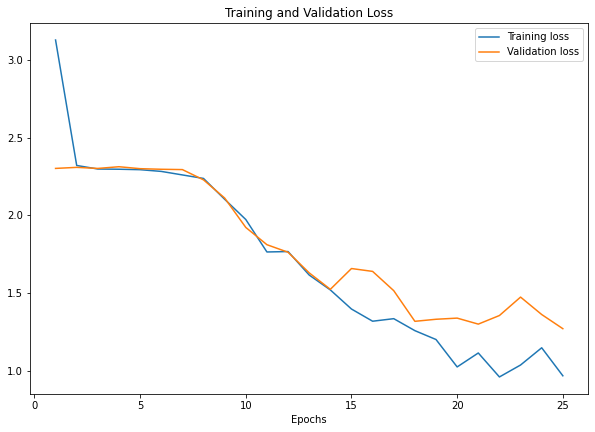

<Figure size 432x288 with 0 Axes>

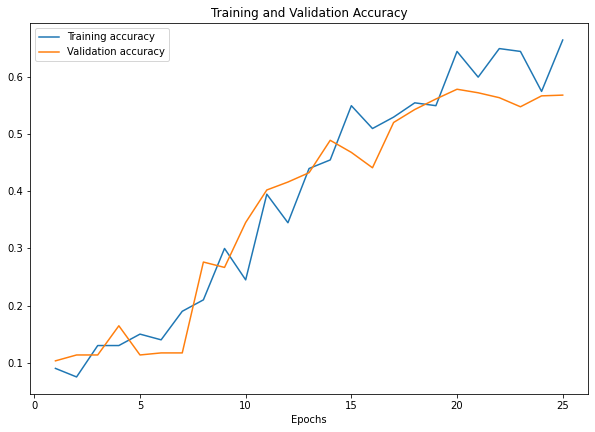

<Figure size 432x288 with 0 Axes>

In [ ]:
# lets look at the plots

epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()


## Learning Rate


In [ ]:
net_lr = OurNet()
net_lr = net_lr.to(device)

# optimizer
import torch.optim as optim

optimizer_lr = optim.Adam(net_lr.parameters(), lr=10)

In [ ]:
# number of loops over the dataset
num_epochs = 5
accuracy = []
val_accuracy = []
losses = []
val_losses = []

for epoch in tnrange(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in tqdm_notebook(enumerate(train_data_loader)):
        print(f"Iteration: {i+1}/{len(train_data_loader)}")
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer_lr.zero_grad()

        # forward + backward + optimize
        outputs = net_lr(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_lr.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_num_correct(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net_lr, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


Iteration: 1/15
Iteration: 2/15
Iteration: 3/15
Iteration: 4/15
Iteration: 5/15
Iteration: 6/15
Iteration: 7/15
Iteration: 8/15
Iteration: 9/15
Iteration: 10/15
Iteration: 11/15
Iteration: 12/15
Iteration: 13/15
Iteration: 14/15
Iteration: 15/15

Epoch: 1
Loss: 693130524.152  Accuracy:0.101
Validation Loss: 982.972  Val Accuracy: 0.101


Iteration: 1/15
Iteration: 2/15
Iteration: 3/15
Iteration: 4/15
Iteration: 5/15
Iteration: 6/15
Iteration: 7/15
Iteration: 8/15
Iteration: 9/15
Iteration: 10/15
Iteration: 11/15
Iteration: 12/15
Iteration: 13/15
Iteration: 14/15
Iteration: 15/15

Epoch: 2
Loss: 194.793  Accuracy:0.102
Validation Loss: 27.786  Val Accuracy: 0.114


Iteration: 1/15
Iteration: 2/15
Iteration: 3/15
Iteration: 4/15
Iteration: 5/15
Iteration: 6/15
Iteration: 7/15
Iteration: 8/15
Iteration: 9/15
Iteration: 10/15
Iteration: 11/15
Iteration: 12/15
Iteration: 13/15
Iteration: 14/15
Iteration: 15/15

Epoch: 3
Loss: 16.903  Accuracy:0.101
Validation Loss: 7.901  Val Accuracy: 0.098


Iteration: 1/15
Iteration: 2/15
Iteration: 3/15
Iteration: 4/15
Iteration: 5/15
Iteration: 6/15
Iteration: 7/15
Iteration: 8/15
Iteration: 9/15
Iteration: 10/15
Iteration: 11/15
Iteration: 12/15
Iteration: 13/15
Iteration: 14/15
Iteration: 15/15

Epoch: 4
Loss: 6.836  Accuracy:0.099
Validation Loss: 5.272  Val Accuracy: 0.103


Iteration: 1/15
Iteration: 2/15
Iteration: 3/15
Iteration: 4/15
Iteration: 5/15
Iteration: 6/15
Iteration: 7/15
Iteration: 8/15
Iteration: 9/15
Iteration: 10/15
Iteration: 11/15
Iteration: 12/15
Iteration: 13/15
Iteration: 14/15
Iteration: 15/15

Epoch: 5
Loss: 3.521  Accuracy:0.102
Validation Loss: 2.938  Val Accuracy: 0.101

Finished Training


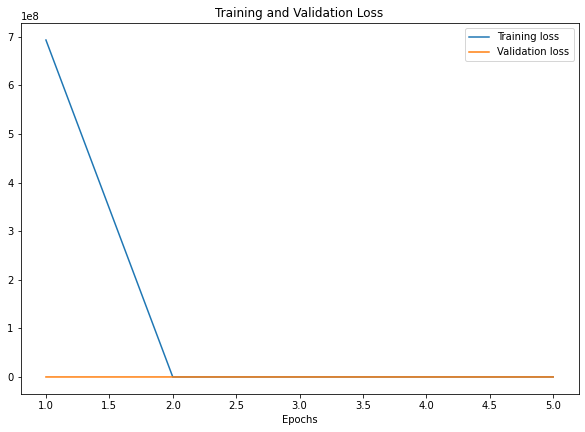

<Figure size 432x288 with 0 Axes>

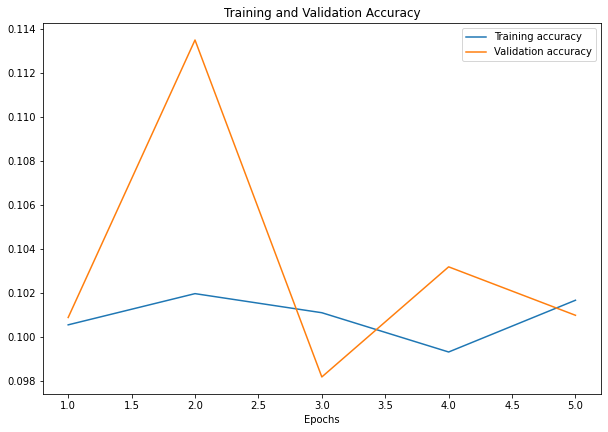

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the graphs

epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()


# Homework - Train a model which achieves at least 80% accuracy on HAM10000

# mount drive

In [ ]:
# exercise 5_2
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/My Drive/CS4MS_Data/HAM10000"

classes = [ 'actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like lesions', 
           'dermatofibroma','melanoma', 'melanocytic nevi', 'vascular lesions']



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import of a couple more modules we need later for loss and accuracy curves
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

# Data Augmentation

In [ ]:
# Normalization values
# https://pytorch.org/hub/pytorch_vision_resnet/

norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)

# define the transformaitons the images go through each time it is used for training
augmentation_train = transforms.Compose([
                                  # resize image to the network input size
                                  transforms.Resize((224,224)),
                                  # randomly perform a horizontal flip of the image
                                  transforms.RandomHorizontalFlip(),
                                  # randomly perform a vertical flip of the image
                                  transforms.RandomVerticalFlip(),
                                  # adjust brightness, contrast, saturation and hue slightly
                                  torchvision.transforms.RandomRotation(degrees=90),
                                  # convert the image into a tensor so it can be processed by the GPU
                                  transforms.ToTensor(),
                                  # normalize the image with the mean and std of ImageNet
                                  transforms.Normalize(norm_mean, norm_std),
                                   ])

augmentation_test = transforms.Compose([
                                  # resize image to the network input size
                                  transforms.Resize((224,224)),
                                  # convert the image into a tensor so it can be processed by the GPU
                                  transforms.ToTensor(),
                                  # normalize the image with the mean and std of ImageNet
                                  transforms.Normalize(norm_mean, norm_std),
                                   ])

# Load dataset

In [ ]:
import torchvision

# create an instance of the image folder class to load images by classes defined with the folders given
dataset = torchvision.datasets.ImageFolder(root= data_dir, transform=augmentation_train)

In [ ]:
import torch
from sklearn.model_selection import train_test_split

# get the total amount of images in the dataset
num_train = len(dataset)

# create a list of indices for the whole dataset
indices = list(range(num_train))

# get the class labels from the dataset object (0-6)
class_labels = dataset.targets

# define the percentage of data that is not used for training
split_size = 0.2

# call a function of sklearn that takes care of splitting the dataset into training and validation+testing
train_indices, test_indices, class_labels_train, class_labels_test = train_test_split(indices,
                                                                                       class_labels,
                                                                                       test_size=split_size,
                                                                                       shuffle=True,
                                                                                       stratify= class_labels,
                                                                                       random_state=42)

# call a function of sklearn that splits training into training and validation
train_indices, val_indices = train_test_split(train_indices,
                                               test_size=split_size,
                                               shuffle=True,
                                               stratify= class_labels_train,
                                               random_state=42)

# Creating data samplers and loaders using the indices:
SubsetRandomSampler = torch.utils.data.sampler.SubsetRandomSampler

# create instances of a torch class for picking random samples from our dataset
train_samples = SubsetRandomSampler(train_indices)
val_samples = SubsetRandomSampler(val_indices)
test_samples = SubsetRandomSampler(test_indices)

Dataloader

In [ ]:
# define the batch size for training, val and testing
batch_size, validation_batch_size, test_batch_size = 16, 16, 16

# create and instance of a dataloader for training
train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8, sampler= train_samples)

# overwrite the dataset instance with the test augmentation (this is not nice code)
dataset = torchvision.datasets.ImageFolder(root= data_dir, transform=augmentation_test)
# create instances of dataloaders for validation and testing
validation_data_loader = torch.utils.data.DataLoader(dataset, batch_size=validation_batch_size, shuffle=False, sampler=val_samples)
test_data_loader = torch.utils.data.DataLoader(dataset, batch_size=test_batch_size, shuffle=False, sampler=test_samples)

# Declare the network

In [ ]:
## Loading a Neural Network
model_ham = torchvision.models.resnet34(pretrained = True)
# or ResNet50, DenseNet , VGG...

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(classes)

# We replace last layer to match our number of classes which is 7
model_ham.fc = nn.Linear(512, num_classes)
print(num_classes)
model_ham = model_ham.to(device)

7


In [ ]:
# Check the dimension of the 1000th image and its corresponding label

image, label = dataset[1000]
print("Image Shape: {} \n Label: {} \n Lesion Type: {}".format(image.shape, label, classes[label]))

Image Shape: torch.Size([3, 224, 224]) 
 Label: 2 
 Lesion Type: benign keratosis-like lesions


Median frequency balancing

In [ ]:
# Median Frequency Balancing, to tackle class imbalance

# get the class labels of each image
class_labels = dataset.targets
# empty array for counting instance of each class
count_labels = np.zeros(len(classes))
# empty array for weights of each class
class_weights = np.zeros(len(classes))

# populate the count array
for l in class_labels:
  count_labels[l] += 1

# get median count
median_freq = np.median(count_labels)

# calculate the weigths
for i in range(len(classes)):
  class_weights[i] = median_freq/count_labels[i]

# print the weights
for i in range(len(classes)):
    print(classes[i],":", class_weights[i])

actinic keratoses : 1.5718654434250765
basal cell carcinoma : 1.0
benign keratosis-like lesions : 0.467697907188353
dermatofibroma : 4.469565217391304
melanoma : 0.4618149146451033
melanocytic nevi : 0.07665920954511558
vascular lesions : 3.619718309859155


# Loss function

In [ ]:
# put the weights on our device
class_weights = torch.FloatTensor(class_weights).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(class_weights)

# Evaluation functions

In [ ]:
from sklearn.metrics import accuracy_score

def get_num_correct(predicted, labels):
    '''
    This function is used to decide if the predicted and ground truth classes are same.
    args: 
      predicted = output of model
      labels = true output
    '''
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate(model, val_loader):
    '''
    This function calculates the total accuracy of the model on the validation set.
    
    args:
      model = the network we want to evaluate
      val_loader = the validation data loader
    '''
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_num_correct(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

Check if running on GPU

In [ ]:
# make sure we are running on GPU
assert str(device) == "cuda", 'If this fails maybe change the runtime: Runtime -> Change runtime type'
print('Nice! Running on the GPU')

Nice! Running on the GPU


# Training loop

In [ ]:
import datetime
start_time = datetime.datetime.now()
import torch.optim as optim
optimizer = optim.Adam(model_ham.parameters(), lr=1e-4) ### smaller than before

num_epochs = 50
accuracy = []
val_accuracy = []
losses = []
val_losses = []

print("Started Training")
epoch = 0
running_loss = 0.0
correct_total= 0.0
num_samples_total=0.0
train_accuracy = 0.0
val_acc=0.0
val_loss = 0.0
print('Epoch: %d' %(epoch+1))
print('Train Loss: %.3f  Train Accuracy:%.3f' %(running_loss, train_accuracy))
print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

for epoch in tnrange(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    
    print("...")
    for i, data in tqdm_notebook(enumerate(train_data_loader)):
        #if i % 50 == 0:
        #    print(f"Iteration: {i+1}/{len(train_data_loader)}")
        
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize   
        outputs = model_ham(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_num_correct(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(model_ham, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Train Loss: %.3f  Train Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')
end_time = datetime.datetime.now()
delta = end_time -start_time
print("Time for training of {} Epochs is {}s".format(num_epochs,delta.seconds))

Started Training
Epoch: 1
Train Loss: 0.000  Train Accuracy:0.000
Validation Loss: 0.000  Val Accuracy: 0.000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch: 1
Train Loss: 1.244  Train Accuracy:0.569
Validation Loss: 1.145  Val Accuracy: 0.611
...



Epoch: 2
Train Loss: 1.553  Train Accuracy:0.462
Validation Loss: 1.277  Val Accuracy: 0.544
...



Epoch: 3
Train Loss: 1.201  Train Accuracy:0.615
Validation Loss: 1.233  Val Accuracy: 0.702
...



Epoch: 4
Train Loss: 1.168  Train Accuracy:0.610
Validation Loss: 1.186  Val Accuracy: 0.620
...



Epoch: 5
Train Loss: 1.012  Train Accuracy:0.649
Validation Loss: 0.972  Val Accuracy: 0.709
...



Epoch: 6
Train Loss: 0.961  Train Accuracy:0.651
Validation Loss: 0.887  Val Accuracy: 0.711
...



Epoch: 7
Train Loss: 0.908  Train Accuracy:0.673
Validation Loss: 1.327  Val Accuracy: 0.636
...



Epoch: 8
Train Loss: 0.919  Train Accuracy:0.656
Validation Loss: 0.917  Val Accuracy: 0.761
...



Epoch: 9
Train Loss: 0.864  Train Accuracy:0.680
Validation Loss: 0.788  Val Accuracy: 0.694
...



Epoch: 10
Train Loss: 0.792  Train Accuracy:0.704
Validation Loss: 1.098  Val Accuracy: 0.564
...



Epoch: 11
Train Loss: 0.809  Train Accuracy:0.709
Validation Loss: 0.889  Val Accuracy: 0.716
...



Epoch: 12
Train Loss: 0.782  Train Accuracy:0.712
Validation Loss: 1.122  Val Accuracy: 0.693
...



Epoch: 13
Train Loss: 0.722  Train Accuracy:0.722
Validation Loss: 0.928  Val Accuracy: 0.631
...



Epoch: 14
Train Loss: 0.714  Train Accuracy:0.722
Validation Loss: 1.057  Val Accuracy: 0.579
...



Epoch: 15
Train Loss: 0.731  Train Accuracy:0.713
Validation Loss: 0.874  Val Accuracy: 0.655
...



Epoch: 16
Train Loss: 0.696  Train Accuracy:0.709
Validation Loss: 0.991  Val Accuracy: 0.553
...



Epoch: 17
Train Loss: 0.699  Train Accuracy:0.731
Validation Loss: 0.763  Val Accuracy: 0.713
...



Epoch: 18
Train Loss: 0.672  Train Accuracy:0.737
Validation Loss: 0.939  Val Accuracy: 0.596
...



Epoch: 19
Train Loss: 0.637  Train Accuracy:0.735
Validation Loss: 0.919  Val Accuracy: 0.696
...



Epoch: 20
Train Loss: 0.598  Train Accuracy:0.736
Validation Loss: 0.915  Val Accuracy: 0.585
...



Epoch: 21
Train Loss: 0.609  Train Accuracy:0.746
Validation Loss: 0.808  Val Accuracy: 0.709
...



Epoch: 22
Train Loss: 0.585  Train Accuracy:0.748
Validation Loss: 1.008  Val Accuracy: 0.745
...



Epoch: 23
Train Loss: 0.573  Train Accuracy:0.761
Validation Loss: 1.118  Val Accuracy: 0.704
...



Epoch: 24
Train Loss: 0.626  Train Accuracy:0.739
Validation Loss: 0.912  Val Accuracy: 0.735
...



Epoch: 25
Train Loss: 0.480  Train Accuracy:0.777
Validation Loss: 1.045  Val Accuracy: 0.758
...



Epoch: 26
Train Loss: 0.544  Train Accuracy:0.758
Validation Loss: 0.922  Val Accuracy: 0.717
...



Epoch: 27
Train Loss: 0.495  Train Accuracy:0.781
Validation Loss: 0.925  Val Accuracy: 0.721
...



Epoch: 28
Train Loss: 0.490  Train Accuracy:0.773
Validation Loss: 0.913  Val Accuracy: 0.663
...



Epoch: 29
Train Loss: 0.490  Train Accuracy:0.766
Validation Loss: 0.921  Val Accuracy: 0.640
...



Epoch: 30
Train Loss: 0.659  Train Accuracy:0.737
Validation Loss: 0.796  Val Accuracy: 0.784
...



Epoch: 31
Train Loss: 0.471  Train Accuracy:0.780
Validation Loss: 0.828  Val Accuracy: 0.744
...



Epoch: 32
Train Loss: 0.473  Train Accuracy:0.780
Validation Loss: 0.722  Val Accuracy: 0.741
...



Epoch: 33
Train Loss: 0.472  Train Accuracy:0.765
Validation Loss: 0.889  Val Accuracy: 0.754
...



Epoch: 34
Train Loss: 0.438  Train Accuracy:0.778
Validation Loss: 1.081  Val Accuracy: 0.755
...



Epoch: 35
Train Loss: 0.401  Train Accuracy:0.800
Validation Loss: 0.787  Val Accuracy: 0.712
...



Epoch: 36
Train Loss: 0.400  Train Accuracy:0.797
Validation Loss: 0.903  Val Accuracy: 0.724
...



Epoch: 37
Train Loss: 0.406  Train Accuracy:0.799
Validation Loss: 0.950  Val Accuracy: 0.736
...



Epoch: 38
Train Loss: 0.431  Train Accuracy:0.798
Validation Loss: 0.903  Val Accuracy: 0.734
...



Epoch: 39
Train Loss: 0.405  Train Accuracy:0.800
Validation Loss: 0.822  Val Accuracy: 0.760
...



Epoch: 40
Train Loss: 0.313  Train Accuracy:0.824
Validation Loss: 1.163  Val Accuracy: 0.793
...



Epoch: 41
Train Loss: 0.422  Train Accuracy:0.808
Validation Loss: 0.975  Val Accuracy: 0.753
...



Epoch: 42
Train Loss: 0.319  Train Accuracy:0.815
Validation Loss: 0.895  Val Accuracy: 0.754
...



Epoch: 43
Train Loss: 0.405  Train Accuracy:0.810
Validation Loss: 1.235  Val Accuracy: 0.711
...



Epoch: 44
Train Loss: 0.391  Train Accuracy:0.812
Validation Loss: 0.884  Val Accuracy: 0.742
...



Epoch: 45
Train Loss: 0.407  Train Accuracy:0.812
Validation Loss: 1.174  Val Accuracy: 0.770
...



Epoch: 46
Train Loss: 0.391  Train Accuracy:0.798
Validation Loss: 0.807  Val Accuracy: 0.767
...



Epoch: 47
Train Loss: 0.360  Train Accuracy:0.819
Validation Loss: 0.953  Val Accuracy: 0.775
...



Epoch: 48
Train Loss: 0.283  Train Accuracy:0.844
Validation Loss: 1.126  Val Accuracy: 0.741
...



Epoch: 49
Train Loss: 0.310  Train Accuracy:0.829
Validation Loss: 1.071  Val Accuracy: 0.734
...



Epoch: 50
Train Loss: 0.302  Train Accuracy:0.837
Validation Loss: 0.972  Val Accuracy: 0.734

Finished Training
Time for training of 50 Epochs is 5367s


# Loss and accuracy curves

50


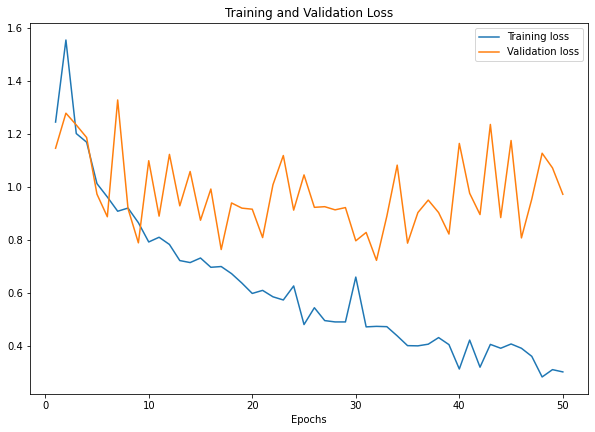

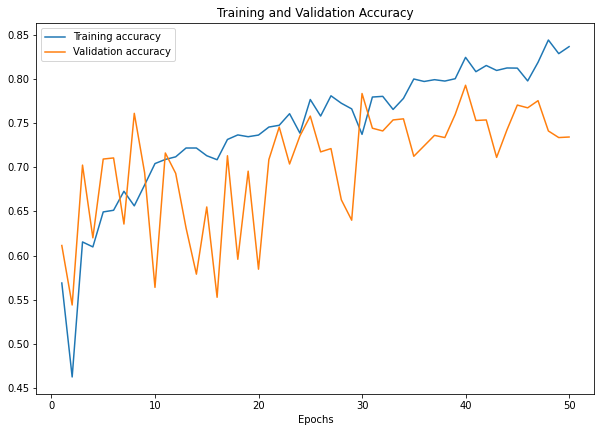

In [ ]:
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline 
num_epochs=50
print(num_epochs)
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
#plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
#plt.figure()
plt.show()

In [ ]:
# share your results with us when you are finished
describe_your_solution = 'deeper network, smaller lr, more augmentation, mfb, '
model_accuracy = '0.837'
assert model_accuracy, "fill in your best accuracy"
write_result('homework', f"{describe_your_solution}\n\n{model_accuracy}")

Task homework successfully solved by FlorianH at 18:09:03 with result: deeper network, smaller lr, more augmentation, mfb, 

0.837
